In [78]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'jshtml'
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import random
import time
random.seed(12345)

In [79]:
class Food(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.is_marked = False

In [80]:
class Bin(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)

In [81]:
# Collector & Explorer
class Waiter(Agent):
    def __init__(self, unique_id, model, x_range):
        super().__init__(unique_id, model)
        self.random.seed(12345)
        self.x_range = x_range
        self.carrying_food = False
        self.in_column = True
        self.horizontal_direction = 1
        self.vertical_direction = 1
        self.current_x = x_range[0]
        self.food_picking_steps = []

    def move(self):
        if self.model.bin_position == None and self.carrying_food == False:
            self.search_bin()
        elif (
            self.carrying_food == True
            and self.model.bin_position != None
            and self.model.agent_in_bin == False
        ):
            self.move_to_target(self.model.bin_position)
        else:
            self.search_food()
            
    def is_cell_available(self, position):
        # Verificar si la celda está disponible (sin otros agentes Waiter).
        return not any(
            isinstance(agent, Waiter)
            for agent in self.model.grid.get_cell_list_contents(position)
        )

    def search_routine(self):
        # Moverse en el eje X
        new_x = self.pos[0] + self.horizontal_direction

        # Verificar si ha llegado al final o al principio del rango de columna
        if new_x > self.x_range[1] or new_x < self.x_range[0]:
            self.horizontal_direction *= -1  # Cambiar dirección horizontal
            new_x = self.pos[0]  # Mantenerse en la misma columna
            new_y = (
                self.pos[1] + self.vertical_direction
            )  # Moverse en la dirección vertical

            # Verificar si ha llegado al final o principio del grid verticalmente
            if new_y >= self.model.grid.height or new_y < 0:
                self.vertical_direction *= -1  # Cambiar dirección vertical
                new_y = (
                    self.pos[1] + self.vertical_direction
                )  # Moverse en la nueva dirección vertical
        else:
            new_y = self.pos[1]

        # Moverse a la nueva posición
        new_position = (new_x, new_y)
        self.model.grid.move_agent(self, new_position)

    def search_bin(self):
        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(
                agent, Bin
            ):  # Suponiendo que Bin es una clase para los agentes contenedor
                self.model.bin_position = self.pos
                return
            elif isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)

        self.search_routine()

    def pick_food(self, agent):
        self.model.grid.remove_agent(agent)
        self.model.schedule.remove(agent)
        self.model.matrix[self.pos[0]][self.pos[1]] = 0
        self.food_picking_steps.append(self.model.schedule.steps)

    def search_food(self):
        # Regresa a su rango de columnas si se sale de él
        if self.pos[0] not in range(self.x_range[0], self.x_range[1] + 1):
            self.move_to_target((self.x_range[0], self.pos[1]))
            return

        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)
                self.carrying_food = True
                self.pick_food(agent)

        self.search_routine()

    def distance_to_target(self, pos, target_pos):
        distance_x, distance_y = pos[0] - target_pos[0], pos[1] - target_pos[1]
        return abs(distance_x) + abs(distance_y)

    def find_nearest_food(self):
        foods = [food for food in self.model.marked_food]
        if not foods:
            return None

        closest = min(foods, key=lambda food: self.distance_to_target(self.pos, food))
        return closest

    def move_to_target(self, target_pos):
        if self.pos == self.model.bin_position and self.carrying_food == True:
            self.place_food()
            self.model.agent_in_bin = False
            return

        if self.pos == target_pos and self.carrying_food == False:
            current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
            for agent in current_cell_contents:
                if isinstance(agent, Food):
                    self.carrying_food = True
                    self.pick_food(agent)
            return

        current_cell_contents = self.model.grid.get_cell_list_contents(self.pos)
        for agent in current_cell_contents:
            if isinstance(agent, Food):
                if agent.is_marked == False:
                    agent.is_marked = True
                    self.model.matrix[self.pos[0]][self.pos[1]] = 1
                    self.model.marked_food.append(agent.pos)

        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=False, include_center=False
        )

        possible_steps = [
            step for step in possible_steps if self.is_cell_available(step)
        ]

        best_step = min(
            possible_steps, key=lambda pos: self.distance_to_target(pos, target_pos)
        )

        self.model.grid.move_agent(self, best_step)

    def place_food(self):
        self.model.agent_in_bin = True
        self.model.grid.place_agent(self, self.model.bin_position)
        self.carrying_food = False
        self.model.food_placed += 1

    def step(self):
        self.move()

In [82]:
def get_grid(model):
    grid = np.zeros((model.grid.width, model.grid.height))
    for (cell_content, (x, y)) in model.grid.coord_iter():
        for content in cell_content:
            if isinstance(content, Bin):
                grid[y][x] = 3
            elif isinstance(content, Food):
                grid[y][x] = 1
            elif isinstance(content, Waiter):
                grid[y][x] = 2
    return grid

In [83]:
class Restaurant(Model):
    def __init__(self, width, height, num_waiters, num_foods):
        self.num_waiters = num_waiters
        self.num_foods = num_foods
        self.total_food = num_foods
        self.schedule = RandomActivation(self)
        self.grid = MultiGrid(width, height, False)
        self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

        self.matrix = np.zeros((width, height))
        self.food_id = 0
        self.last_food_creation_time = time.time()
        self.column_width = None
        self.bin_position = None
        self.marked_food = []
        self.food_placed = 0
        self.is_running = True
        self.agent_in_bin = False

        self.create_waiters()
        self.create_bin()
        self.create_foods()

    def random_position(self):
        x = random.randrange(self.grid.width)
        y = random.randrange(self.grid.height)
        return (x, y)

    def create_bin(self):
        bin_id = "bin"
        x, y = self.random_position()
        bin = Bin(bin_id, self)
        self.schedule.add(bin)
        self.grid.place_agent(bin, (x, y))

    def create_foods(self):
        food_unit = random.randint(2, 5)

        if food_unit > self.num_foods:
            food_unit = self.num_foods

        for i in range(food_unit):
            food_id = "food-" + str(self.food_id)
            while True:
                x, y = self.random_position()
                if self.grid.is_cell_empty((x, y)):
                    food = Food(food_id, self)
                    self.schedule.add(food)
                    self.grid.place_agent(food, (x, y))
                    self.food_id += 1
                    break
        self.num_foods -= food_unit

    def create_waiters(self):
        self.column_width =  self.grid.width // self.num_waiters
        column = 0
        for i in range(self.num_waiters):
            waiter_id = "waiter-" + str(i)
            while True:
                x = self.random.randrange(column, column + self.column_width - 1)
                x_range = (column, column + self.column_width - 1)
                y = self.random.randrange(self.grid.height)
                if self.grid.is_cell_empty((x, y)):
                    waiter = Waiter(waiter_id, self, x_range)
                    self.schedule.add(waiter)
                    self.grid.place_agent(waiter, (x, y))
                    break
            column += self.column_width

    def simulation_finished(self):
        if self.food_placed == self.total_food:
            self.is_running = False

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()
        self.simulation_finished()
            

In [84]:
# CONSTANTS
WIDTH = 20
HEIGHT = 20
NUM_WAITERS = 5
NUM_FOODS = 47

In [85]:
model = Restaurant(WIDTH, HEIGHT, NUM_WAITERS, NUM_FOODS)
for i in range(100):
    model.step()
    if model.is_running == False:
        break
print("Numero de pasos: ", model.schedule.steps)
number_of_steps = model.schedule.steps
data = model.datacollector.get_model_vars_dataframe()

Numero de pasos:  100


C:\Users\santi\AppData\Local\Temp\ipykernel_18696\3654389262.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch = plt.imshow(data.iloc[0][0], cmap="Blues")
C:\Users\santi\AppData\Local\Temp\ipykernel_18696\3654389262.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  patch.set_data(data.iloc[i][0])


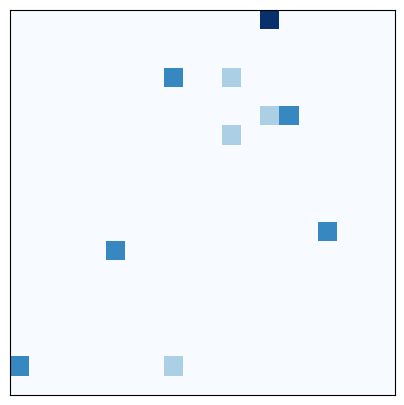

In [86]:
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])
patch = plt.imshow(data.iloc[0][0], cmap="Blues")

def animate(i):
    patch.set_data(data.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=number_of_steps, interval=10)

anim